# Capstone Project: The Battle of Neighbourhoods Week 1

_By Ivan Alarcon_

## 1. Introduction

Mazatlan is a coastal city in Sinaloa Mexico in which seafood is mainly consumed, but which has begun to have a demographic and cultural growth, in which the consumption of meat in BBQs has increased, and the demand for better quality cut increases equally. 

The client wants to take advantage of this demand and open a butcher shop with fine cuts and better quality of exported meat. The client wants to see which are the best neighborhoods in which he can open his store and that have a greater demand for these products since the preference for Seafood for even greater in most of the city.

## 2. Data

This project will rely on public data from internet and Foursquare.   

for this project we download the information of Postal codes and create an excel.

In [2]:
# library to handle data in a vectorized manner
import numpy as np

# library for BeautifulSoup
from bs4 import BeautifulSoup

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# library to handle requests
import requests

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the Geocoder
import geocoder

# import time
import time

import folium # map rendering library
print('...Done')

...Done


In [12]:
df=pd.read_excel('mazatlan.xlsx')
df.rename(columns={'Código Postal': 'Postcode', 'Ciudad': 'Borough', 'Asentamiento': 'Neighborhood'}, inplace=True)
df.head()

,Postcode,Borough,Neighborhood
0,82020,Mazatlan,12 de Mayo
1,82150,Mazatlan,20 de Noviembre
2,82089,Mazatlan,23 de Noviembre
3,82090,Mazatlan,2a Ampliación Felipe Angeles
4,82090,Mazatlan,2da. Ampliación Valle de Urias


In [13]:
df_neighborhood = df.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
df_neighborhood.columns = ['Postcode', 'Borough', 'Neighborhood']
df_neighborhood

,Postcode,Borough,Neighborhood
0,82000,Mazatlan,"Balcones de Loma Linda, Centro, Los Pinos"
1,82007,Mazatlan,Loma Linda
2,82010,Mazatlan,"Campo Bello, Estero, Independencia, Juan Carra..."
3,82013,Mazatlan,Ferrocarrilera
4,82014,Mazatlan,San Angel
5,82015,Mazatlan,Trópico de Cáncer
6,82016,Mazatlan,Brisas del Mar
7,82017,Mazatlan,Telleria
8,82018,Mazatlan,Insurgentes
9,82019,Mazatlan,Tierra y Libertad


In [14]:
df_neighborhood.shape

(83, 3)

In [21]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Mazatlan, Mexico'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [22]:
sample = get_latlng('82000')
sample

[23.201530000000048, -106.42220797999994]

In [23]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

<[OK] Geocodefarm - Reverse [Calle Guillermo Nelson 28, Mazatlán Centro, 82000 Mazatlán, Sinaloa, Mexico]>

In [24]:
start = time.time()

postal_codes = df_neighborhood['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  148.40482997894287 seconds


In [27]:
df_mazatlan = df_neighborhood

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [28]:
df_mazatlan.head(5)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,82000,Mazatlan,"Balcones de Loma Linda, Centro, Los Pinos",23.201530,-106.422208
1,82007,Mazatlan,Loma Linda,23.202910,-106.429739
2,82010,Mazatlan,"Campo Bello, Estero, Independencia, Juan Carra...",23.219220,-106.412326
3,82013,Mazatlan,Ferrocarrilera,23.216662,-106.419500
4,82014,Mazatlan,San Angel,23.225210,-106.419385


In [29]:
df_mazatlan.shape

(83, 5)

In [31]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_mazatlan['Borough'].unique()),
        df_mazatlan.shape[0]
    )
)

The dataframe has 1 boroughs and 83 neighborhoods.


## 3. Methodology  

### Data exploration

In [40]:
CLIENT_ID = 'NTH1P4YBRKCB5A1N0BLPCZSD1EM3A3FYVCBPIVM0MJI4DA0L' # your Foursquare ID
CLIENT_SECRET = 'HH4LVBEMIC1NHSGRLAYQUCR4TQQWZKA2UCI0EGEUE4DOJVJS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NTH1P4YBRKCB5A1N0BLPCZSD1EM3A3FYVCBPIVM0MJI4DA0L
CLIENT_SECRET:HH4LVBEMIC1NHSGRLAYQUCR4TQQWZKA2UCI0EGEUE4DOJVJS


In [41]:
df_mazatlan.loc[0, 'Neighborhood']

'Balcones de Loma Linda, Centro, Los Pinos'

In [48]:
neighborhood_latitude = df_mazatlan.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_mazatlan.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_mazatlan.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Balcones de Loma Linda, Centro, Los Pinos are 23.201530000000048, -106.42220797999994.


In [49]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NTH1P4YBRKCB5A1N0BLPCZSD1EM3A3FYVCBPIVM0MJI4DA0L&client_secret=HH4LVBEMIC1NHSGRLAYQUCR4TQQWZKA2UCI0EGEUE4DOJVJS&v=20180605&ll=23.201530000000048,-106.42220797999994&radius=500&limit=100'

In [50]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f1f8ced4d24b7155052e51e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Mazatlán',
  'headerFullLocation': 'Mazatlán',
  'headerLocationGranularity': 'city',
  'totalResults': 27,
  'suggestedBounds': {'ne': {'lat': 23.206030004500054,
    'lng': -106.41732115463907},
   'sw': {'lat': 23.197029995500042, 'lng': -106.42709480536081}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d18fddcbb488cfaa53fb9d4',
       'name': 'Panamá Restaurant & Pastelería',
       'location': {'address': 'J.M cañizales',
        'lat': 23.201472848921306,
        'lng': -106.4216002899587,
        'labeledLatLngs': [{'label': 'display',
          'lat': 23.201

In [51]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [52]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/ivan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Panamá Restaurant & Pastelería,Mexican Restaurant,23.201473,-106.421600
1,Centro Histórico,Plaza,23.200476,-106.421991
2,Nieves Don Hilario,Ice Cream Shop,23.201349,-106.421670
3,Nieves de Garrafa Medrano,Ice Cream Shop,23.199772,-106.422735
4,Sr. Frogs Store,Gift Shop,23.201437,-106.421656


In [53]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')

In [54]:
nearby_venues_lewisham_unique.head(5)

,Count
Ice Cream Shop,3
Mexican Restaurant,3
Restaurant,2
Pizza Place,2
Plaza,2


In [55]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

27 venues were returned by Foursquare.


In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
mazatlan_venues = getNearbyVenues(names=df_mazatlan['Neighborhood'],
                                   latitudes=df_mazatlan['Latitude'],
                                   longitudes=df_mazatlan['Longitude']
                                  )

Balcones de Loma Linda, Centro, Los Pinos
Loma Linda
Campo Bello, Estero, Independencia, Juan Carrasco, Libertad, Lomas del Mar, Palmeiras Club Residencial, Palos Prietos
Ferrocarrilera
San Angel
Trópico de Cáncer
Brisas del Mar
Telleria
Insurgentes
Tierra y Libertad
12 de Mayo, Bahías, Klein, Nueva Creación
Casas Económicas
Montuosa, Reforma
Sanchez Taboada
Francisco Solís
Obrera
Cerro del Vigía, Gabriel Leyva, Lázaro Cárdenas, Playas del Sur, Villas Playa Sur
Anabella de Gavica, Ecológica, Isla de la Piedra, José de Nazaret, Vicente Guerrero
Octava Zona Naval (Puerto Mazatlan)
Cerro de La Cruz
Alfredo V. Bonfil, Las Malvinas
Casa Redonda
Francisco I Madero, José María Pino Suárez
Ejido Rincón de Urías
5ta Chapalita, Gral. Rafael Buelna
23 de Noviembre, La Sirena, Miramar
2a Ampliación Felipe Angeles, 2da. Ampliación Valle de Urias, Ana Paula, Diaz Ordaz, Felipe, Felipe Angeles, Hacienda de Urias, Las Flores, María del Mar, Santa Teresa, Urbivilla del Real, Valle de Urias
Ampliación d

In [65]:
mazatlan_venues.shape

(4838, 7)

In [66]:
mazatlan_venues['Neighbourhood'].value_counts()
mazatlan_venues.to_csv('mazatlan_venues.csv')
mazatlan_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208,Panamá Restaurant & Pastelería,23.201473,-106.421600,Mexican Restaurant
1,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208,Centro Histórico,23.200476,-106.421991,Plaza
2,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208,Nieves Don Hilario,23.201349,-106.421670,Ice Cream Shop
3,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208,Hector's Bistro,23.199166,-106.423830,French Restaurant
4,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208,Nieves de Garrafa Medrano,23.199772,-106.422735,Ice Cream Shop


In [68]:
mazatlan_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"12 de Mayo, Bahías, Klein, Nueva Creación",63,63,63,63,63,63
"20 de Noviembre, El Castillo, Los Ángeles (Santa Fe), Olímpica, Villa de Jacaro, Villa Galaxia, Villa Satélite",69,69,69,69,69,69
"23 de Noviembre, La Sirena, Miramar",5,5,5,5,5,5
"2a Ampliación Felipe Angeles, 2da. Ampliación Valle de Urias, Ana Paula, Diaz Ordaz, Felipe, Felipe Angeles, Hacienda de Urias, Las Flores, María del Mar, Santa Teresa, Urbivilla del Real, Valle de Urias",4,4,4,4,4,4
"5a. Gaviotas, El Cid, El Dorado, Ex Laguna Las Gaviotas, Las Gaviotas, Lomas de Mazatlan, Puerta Dorada, Zona Dorada",100,100,100,100,100,100
"5ta Chapalita, Gral. Rafael Buelna",6,6,6,6,6,6
"Alameda, Jardines de la Alameda",100,100,100,100,100,100
"Alfredo V. Bonfil, Las Malvinas",10,10,10,10,10,10
"Almar, Azul Marino, Azul Pacific, Cerritos al Mar, Cerritos Resort, El Palmar, Las Palmas, Marina del Rey, Marina Garden, Marina Kelly, Palmilla, Playa Linda, Quintas del Mar, Real del Mar, Royal Country, Villa del Mar, Villa Marina, Villa Tranquila, Villas de Rueda",38,38,38,38,38,38


In [70]:
print('There are {} uniques categories.'.format(len(mazatlan_venues['Venue Category'].unique())))

There are 138 uniques categories.


In [72]:
mazatlan_venues_unique_count = mazatlan_venues['Venue Category'].value_counts().to_frame(name='Count')

In [75]:
mazatlan_venues_unique_count

,Count
Taco Place,664
Seafood Restaurant,638
Mexican Restaurant,287
Restaurant,191
Convenience Store,174
Sushi Restaurant,145
Pizza Place,143
Beach,132
Burger Joint,104
Hotel,104


In [76]:
mazatlan_venues_unique_count.describe()

,Count
count,138.000000
mean,35.057971
std,85.236448
min,1.000000
25%,6.000000
50%,13.000000
75%,26.000000
max,664.000000


In [77]:
address = 'Mazatlan, Mexico'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mazatlan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mazatlan are 23.2313053, -106.4153144.


In [78]:
# df_mazatlan_coordinates
map_mazatlan = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_mazatlan 

In [81]:
# Adding markers to map
for lat, lng, borough, loc in zip(df_mazatlan['Latitude'], 
                                  df_mazatlan['Longitude'],
                                  df_mazatlan['Borough'],
                                  df_mazatlan['Neighborhood']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_mazatlan)  
    
display(map_mazatlan)

In [82]:
# one hot encoding
mazatlan_onehot = pd.get_dummies(mazatlan_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [84]:
# add neighborhood column back to dataframe
mazatlan_onehot['Neighbourhood'] = mazatlan_venues['Neighbourhood']

In [85]:
# move neighborhood column to the first column
fixed_columns = [mazatlan_onehot.columns[-1]] + list(mazatlan_onehot.columns[:-1])
mazatlan_onehot = mazatlan_onehot[fixed_columns]

In [86]:
mazatlan_onehot.head()

,Neighbourhood,Accessories Store,Airport,Aquarium,Argentinian Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Cantonese Restaurant,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cuban Restaurant,Department Store,Dessert Shop,Diner,Dive Bar,Electronics Store,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lighthouse,Liquor Store,Lounge,Market,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Mountain,Movie Theater,Multiplex,Nightclub,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Water Park,Waterfront,Wings Joint
0,"Balcones de Loma Linda, Centro, Los Pinos",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Balcones de Loma Linda, Centro, Los Pinos",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Balcones de Loma Linda, Centro, Los Pinos",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Balcones de Loma Linda, Centro, Los Pinos",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Balcones de Loma Linda, Centro, Los Pinos",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
mazatlan_onehot.loc[mazatlan_onehot['Steakhouse'] != 0]

,Neighbourhood,Accessories Store,Airport,Aquarium,Argentinian Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Cantonese Restaurant,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cuban Restaurant,Department Store,Dessert Shop,Diner,Dive Bar,Electronics Store,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lighthouse,Liquor Store,Lounge,Market,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Mountain,Movie Theater,Multiplex,Nightclub,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Water Park,Waterfront,Wings Joint
626,Brisas del Mar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
801,Insurgentes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
816,Insurgentes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
896,Tierra y Libertad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
916,Tierra y Libertad,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1756,"Las Varas, Sábalo Country Club",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2055,"5a. Gaviotas, El Cid, El Dorado, Ex Laguna Las...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2272,Rincón Colonial,0,0,0,0,0,0,0,0,0,

In [89]:
mazatlan_onehot.to_csv('mazatlan_data_onehot.csv', index = False)

In [90]:
mazatlan_onehot.shape

(4838, 139)

## Grouping by neighborhood

In [91]:
mazatlan_grouped = mazatlan_onehot.groupby('Neighbourhood').mean().reset_index()
mazatlan_grouped.head()

,Neighbourhood,Accessories Store,Airport,Aquarium,Argentinian Restaurant,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Candy Store,Cantonese Restaurant,Casino,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Creperie,Cuban Restaurant,Department Store,Dessert Shop,Diner,Dive Bar,Electronics Store,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Latin American Restaurant,Lighthouse,Liquor Store,Lounge,Market,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Mountain,Movie Theater,Multiplex,Nightclub,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soup Place,Spa,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tennis Stadium,Thai Restaurant,Theater,Theme Park Ride / Attraction,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Water Park,Waterfront,Wings Joint
0,"12 de Mayo, Bahías, Klein, Nueva Creación",0.015873,0.015873,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015873,0.015873,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.031746,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.015873,0.000000,0.0,0.015873,0.0,0.079365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031746,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.015873,0.0,0.000000,0.015873,0.015873,0.00,0.00,0.0,0.015873,0.0,0.0,0.0,0.015873,0.0,0.031746,0.0,0.0,0.000000,0.00,0.015873,0.0,0.031746,0.00,0.0,0.0,0.015873,0.015873,0.095238,0.0,0.015873,0.0,0.0,0.000000,0.000000,0.0,0.015873,0.000000,0.0,0.00,0.031746,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.015873,0.0,0.0,0.0,0.0,0.0,0.174603,0.015873,0.00,0.000000,0.015873,0.000000,0.0,0.000000,0.00,0.0,0.00,0.0,0.000000,0.0,0.00,0.00,0.031746,0.111111,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000
1,"20 de Noviembre, El Castillo, Los Ángeles (San...",0.000000,0.014493,0.0,0.00,0.0,0.014493,0.014493,0.014493,0.014493,0.00,0.014493,0.000000,0.000000,0.0,0.00,0.014493,0.0,0.014493,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.028986,0.0,0.014493,0.0,0.0,0.00,0.0,0.0,0.000000,0.028986,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072464,0.028986,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.014493,0.0,0.014493,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.014493,0.00,0.000000,0.0,0.014493,0.00,0.0,0.0,0.000000,0.014493,0.072464,0.0,0.000000,0.0,0.0,0.014493,0.014493,0.0,0.000000,0.014493,0.0,0.00,0.028986,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.028986,0.0,0.0,0.0,0.0,0.0,0.057971,0.014493,0.00,0.014493,0.000000,0.014493,0.0,0.014493,0.00,0.0,0.00,0.0,0.014493,0.0,0.00,0.00,0.043478,0.173913,0.0,0.00,0.014493,0.0,0.0,0.0,0.00,0.0,0.0,0.014493
2,"23 de Noviembre, La Sirena, Miramar",0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.2,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,

In [93]:
print("Before One-hot encoding:", df_mazatlan.shape)
print("After One-hot encoding:", mazatlan_grouped.shape)

Before One-hot encoding: (83, 5)
After One-hot encoding: (83, 139)


In [94]:
mazatlan_grouped.to_csv('mazatlan_grouped.csv', index = False)

In [95]:
num_top_venues = 10 # Top common venues needed

for hood in mazatlan_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = mazatlan_grouped[mazatlan_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----12 de Mayo, Bahías, Klein, Nueva Creación----
                venue  freq
0  Seafood Restaurant  0.17
1          Taco Place  0.11
2  Mexican Restaurant  0.10
3   Convenience Store  0.08
4         Pizza Place  0.05
5            Pharmacy  0.03
6           Juice Bar  0.03
7               Hotel  0.03
8         Flea Market  0.03
9        Burger Joint  0.03


----20 de Noviembre, El Castillo, Los Ángeles (Santa Fe), Olímpica, Villa de Jacaro, Villa Galaxia, Villa Satélite----
                  venue  freq
0            Taco Place  0.17
1    Mexican Restaurant  0.07
2  Fast Food Restaurant  0.07
3    Seafood Restaurant  0.06
4           Pizza Place  0.04
5      Sushi Restaurant  0.04
6     Convenience Store  0.04
7    Chinese Restaurant  0.03
8            Restaurant  0.03
9           Flea Market  0.03


----23 de Noviembre, La Sirena, Miramar----
                           venue  freq
0                  Boat or Ferry   0.2
1              Convenience Store   0.2
2                          M

                venue  freq
0      Clothing Store  0.07
1      Ice Cream Shop  0.07
2   Convenience Store  0.07
3          Taco Place  0.05
4  Seafood Restaurant  0.05
5       Shopping Mall  0.04
6           Juice Bar  0.03
7       Movie Theater  0.03
8          Food Truck  0.03
9      Gymnastics Gym  0.03


----Bosques del Arroyo, Buenos Aires, Colinas del Real, Jaripillo, José Gordillo Pinto, La Campiña, María Antonieta, Montebello, Petróleos, Santa Laura, Torremolinos Costa Azul, Valle Bonito, Villa Tutuli, Villa Tutuli II----
                venue  freq
0   Convenience Store  0.14
1          Taco Place  0.14
2  Mexican Restaurant  0.10
3              Bakery  0.10
4    Business Service  0.05
5      Baseball Field  0.05
6                 Gym  0.05
7  Seafood Restaurant  0.05
8        Soccer Field  0.05
9         Pizza Place  0.05


----Brisas del Mar----
                venue  freq
0  Seafood Restaurant  0.17
1          Taco Place  0.14
2  Mexican Restaurant  0.08
3        Burger Joi

                           venue  freq
0                     Taco Place  0.33
1              Convenience Store  0.17
2          Street Food Gathering  0.17
3                           Park  0.17
4             Seafood Restaurant  0.17
5              Accessories Store  0.00
6                      Nightclub  0.00
7              Outdoor Sculpture  0.00
8  Paper / Office Supplies Store  0.00
9                      Pet Store  0.00


----Girasoles----
                  venue  freq
0            Taco Place  0.17
1    Seafood Restaurant  0.10
2    Mexican Restaurant  0.05
3            Restaurant  0.05
4      Sushi Restaurant  0.05
5                 Beach  0.04
6           Pizza Place  0.04
7  Fast Food Restaurant  0.03
8                Bakery  0.03
9        Ice Cream Shop  0.03


----Hacienda Las Cruces----
                  venue  freq
0            Taco Place  0.18
1    Seafood Restaurant  0.09
2    Mexican Restaurant  0.05
3            Restaurant  0.05
4      Sushi Restaurant  0.05
5          

----Villas del Estero----
                venue  freq
0          Taco Place  0.20
1  Seafood Restaurant  0.14
2  Mexican Restaurant  0.06
3        Burger Joint  0.05
4    Sushi Restaurant  0.05
5         Pizza Place  0.04
6          Restaurant  0.04
7          Steakhouse  0.02
8         Flea Market  0.02
9           Gift Shop  0.02




In [96]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = mazatlan_grouped['Neighbourhood']

for ind in np.arange(mazatlan_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mazatlan_grouped.iloc[ind, :], num_top_venues)

In [99]:
neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"12 de Mayo, Bahías, Klein, Nueva Creación",Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Pizza Place,Burger Joint,Hotel,Flea Market,Juice Bar,Sushi Restaurant
1,"20 de Noviembre, El Castillo, Los Ángeles (San...",Taco Place,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,Convenience Store,Sushi Restaurant,Pizza Place,Pharmacy,Flea Market,Restaurant
2,"23 de Noviembre, La Sirena, Miramar",Boat or Ferry,Sushi Restaurant,Harbor / Marina,Convenience Store,Motel,Food,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store
3,"2a Ampliación Felipe Angeles, 2da. Ampliación ...",Golf Course,Taco Place,Big Box Store,Brewery,Flea Market,Fast Food Restaurant,Electronics Store,Dive Bar,Diner,Wings Joint
4,"5a. Gaviotas, El Cid, El Dorado, Ex Laguna Las...",Seafood Restaurant,Mexican Restaurant,Taco Place,Restaurant,Sushi Restaurant,Beach,Café,Hotel,Bar,Bakery


In [100]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)

In [102]:
mazatlan_grouped_clustering = mazatlan_grouped.drop('Neighbourhood', 1)

In [104]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(mazatlan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 3, 2, 1, 0, 3, 2, 0], dtype=int32)

In [105]:
kmeans.labels_[0:10]

array([0, 0, 4, 3, 2, 1, 0, 3, 2, 0], dtype=int32)

In [106]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [108]:
mazatlan_merged = df_mazatlan

In [109]:
mazatlan_merged.head(3)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,82000,Mazatlan,"Balcones de Loma Linda, Centro, Los Pinos",23.20153,-106.422208
1,82007,Mazatlan,Loma Linda,23.20291,-106.429739
2,82010,Mazatlan,"Campo Bello, Estero, Independencia, Juan Carra...",23.21922,-106.412326


In [112]:
# match/merge SE London data with latitude/longitude for each neighborhood
mazatlan_merged_latlong = mazatlan_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Neighborhood')

In [113]:
mazatlan_merged_latlong.head(5)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,82000,Mazatlan,"Balcones de Loma Linda, Centro, Los Pinos",23.201530,-106.422208,2,Seafood Restaurant,Taco Place,Restaurant,Mexican Restaurant,Historic Site,Beach,Scenic Lookout,Ice Cream Shop,Harbor / Marina,Café
1,82007,Mazatlan,Loma Linda,23.202910,-106.429739,2,Seafood Restaurant,Restaurant,Mexican Restaurant,Beach,Historic Site,Taco Place,Scenic Lookout,Ice Cream Shop,Plaza,Sandwich Place
2,82010,Mazatlan,"Campo Bello, Estero, Independencia, Juan Carra...",23.219220,-106.412326,2,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Beach,Pizza Place,Hotel,Sushi Restaurant,Candy Store,Pharmacy
3,82013,Mazatlan,Ferrocarrilera,23.216662,-106.419500,2,Seafood Restaurant,Mexican Restaurant,Taco Place,Beach,Historic Site,Hotel,Pizza Place,Restaurant,Convenience Store,Sushi Restaurant
4,82014,Mazatlan,San Angel,23.225210,-106.419385,0,Seafood Restaurant,Taco Place,Burger Joint,Mexican Restaurant,Convenience Store,Beach,Pizza Place,Juice Bar,Sushi Restaurant,Restaurant


In [114]:
mazatlan_clusters = mazatlan_merged_latlong

In [115]:
%matplotlib inline
import matplotlib
import numpy as np

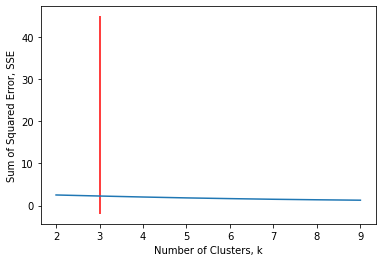

In [118]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(mazatlan_grouped_clustering)
    mazatlan_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

In [119]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(mazatlan_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(mazatlan_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6695111908946947
Where n_clusters = 3, the Silhouette Coefficient is 0.7200271961825301
Where n_clusters = 4, the Silhouette Coefficient is 0.7153895933549392
Where n_clusters = 5, the Silhouette Coefficient is 0.7469305888510608
Where n_clusters = 6, the Silhouette Coefficient is 0.7864586782319454
Where n_clusters = 7, the Silhouette Coefficient is 0.8200196276959135
Where n_clusters = 8, the Silhouette Coefficient is 0.8211603260782444
Where n_clusters = 9, the Silhouette Coefficient is 0.8181879507071275


In [120]:
mazatlan_clusters.columns

Index(['Postcode', 'Borough', 'Neighborhood', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [122]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mazatlan_clusters['Latitude'], mazatlan_clusters['Longitude'], mazatlan_clusters['Neighborhood'], mazatlan_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

In [123]:
mazatlan_clusters.loc[mazatlan_clusters['Cluster Labels'] == 0, mazatlan_clusters.columns[[1] + list(range(5, mazatlan_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Mazatlan,0,Seafood Restaurant,Taco Place,Burger Joint,Mexican Restaurant,Convenience Store,Beach,Pizza Place,Juice Bar,Sushi Restaurant,Restaurant
6,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Burger Joint,Beach,Sushi Restaurant,Pizza Place,Hotel,Flea Market,Juice Bar
7,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Burger Joint,Beach,Sushi Restaurant,Pizza Place,Hotel,Juice Bar,Restaurant
8,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Burger Joint,Sushi Restaurant,Pizza Place,Restaurant,Coffee Shop,Beach,Convenience Store
9,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Sushi Restaurant,Restaurant,Burger Joint,Fast Food Restaurant,Pizza Place,Beach,Steakhouse
10,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Pizza Place,Burger Joint,Hotel,Flea Market,Juice Bar,Sushi Restaurant
11,Mazatlan,0,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Flea Market,Burger Joint,Hotel,Golf Course,Big Box Store,Shipping Store
34,Mazatlan,0,Taco Place,Seafood Restaurant,Restaurant,Mexican Restaurant,Beach,Café,Pharmacy,Sushi Restaurant,Bakery,Pizza Place
35,Mazatlan,0,Taco Place,Seafood Restaurant,Fast Food Restaurant,Sushi Restaurant,Pharmacy,Burger Joint,Ice Cream Shop,Restaurant,Mexican Restaurant,Pizza Place
36,Mazatlan,0,Taco Place,Seafood Restaurant,Mexican Restaurant,Restaurant,Bakery,Sushi Restaurant,Fast Food Restaurant,Ice Cream Shop,Beach,Café


In [124]:
mazatlan_clusters.loc[mazatlan_clusters['Cluster Labels'] == 1, mazatlan_clusters.columns[[1] + list(range(5, mazatlan_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Mazatlan,1,Taco Place,Bakery,BBQ Joint,Pizza Place,Golf Course,Soccer Field,Sushi Restaurant,Big Box Store,Auto Garage,Athletics & Sports
24,Mazatlan,1,Convenience Store,Taco Place,Golf Course,Hotel,Big Box Store,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store,Dive Bar
27,Mazatlan,1,Taco Place,Harbor / Marina,Brewery,Convenience Store,Motel,Hotel,Comfort Food Restaurant,Coffee Shop,Creperie,Cuban Restaurant
43,Mazatlan,1,Convenience Store,Taco Place,Pizza Place,Mexican Restaurant,Bakery,Sushi Restaurant,Shipping Store,Shop & Service,Juice Bar,Movie Theater
47,Mazatlan,1,Convenience Store,Taco Place,Mexican Restaurant,Bakery,Baseball Field,Shop & Service,Seafood Restaurant,Soccer Field,Pizza Place,Juice Bar
48,Mazatlan,1,Taco Place,Convenience Store,Mexican Restaurant,Bakery,Soccer Field,Pizza Place,Seafood Restaurant,Juice Bar,Movie Theater,Shop & Service
50,Mazatlan,1,Taco Place,Baseball Field,Pizza Place,Convenience Store,Athletics & Sports,Juice Bar,Sushi Restaurant,Flower Shop,Flea Market,Fast Food Restaurant
65,Mazatlan,1,Convenience Store,Taco Place,Sushi Restaurant,Mexican Restaurant,Soccer Field,Movie Theater,Mobile Phone Shop,Shop & Service,Board Shop,Juice Bar
68,Mazatlan,1,Taco Place,Convenience Store,Burger Joint,Seafood Restaurant,Mexican Restaurant,Bakery,Sushi Restaurant,Flea Market,Soccer Field,Juice Bar
77,Mazatlan,1,Taco Place,Convenience Store,Bakery,Auto Garage,Soccer Field,Pizza Place,Creperie,Comfort Food Restaurant,Cuban Restaurant,Coffee Shop


In [125]:
mazatlan_clusters.loc[mazatlan_clusters['Cluster Labels'] == 2, mazatlan_clusters.columns[[1] + list(range(5, mazatlan_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mazatlan,2,Seafood Restaurant,Taco Place,Restaurant,Mexican Restaurant,Historic Site,Beach,Scenic Lookout,Ice Cream Shop,Harbor / Marina,Café
1,Mazatlan,2,Seafood Restaurant,Restaurant,Mexican Restaurant,Beach,Historic Site,Taco Place,Scenic Lookout,Ice Cream Shop,Plaza,Sandwich Place
2,Mazatlan,2,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Beach,Pizza Place,Hotel,Sushi Restaurant,Candy Store,Pharmacy
3,Mazatlan,2,Seafood Restaurant,Mexican Restaurant,Taco Place,Beach,Historic Site,Hotel,Pizza Place,Restaurant,Convenience Store,Sushi Restaurant
5,Mazatlan,2,Seafood Restaurant,Taco Place,Restaurant,Beach,Mexican Restaurant,Historic Site,Scenic Lookout,Ice Cream Shop,Bakery,Sandwich Place
12,Mazatlan,2,Seafood Restaurant,Taco Place,Mexican Restaurant,Restaurant,Historic Site,Beach,Pizza Place,Pharmacy,Hotel,Ice Cream Shop
13,Mazatlan,2,Seafood Restaurant,Mexican Restaurant,Taco Place,Restaurant,Pizza Place,Ice Cream Shop,Beach,Historic Site,Pharmacy,Convenience Store
14,Mazatlan,2,Seafood Restaurant,Taco Place,Mexican Restaurant,Convenience Store,Beach,Pizza Place,Juice Bar,Ice Cream Shop,Hotel,Sushi Restaurant
15,Mazatlan,2,Seafood Restaurant,Mexican Restaurant,Taco Place,Convenience Store,Ice Cream Shop,Candy Store,Hotel,Beach,Juice Bar,Gift Shop
16,Mazatlan,2,Seafood Restaurant,Scenic Lookout,Restaurant,Historic Site,Beach,Taco Place,Mexican Restaurant,Ice Cream Shop,Lighthouse,Bakery


In [126]:
mazatlan_clusters.loc[mazatlan_clusters['Cluster Labels'] == 3, mazatlan_clusters.columns[[1] + list(range(5, mazatlan_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Mazatlan,3,Taco Place,Flea Market,Big Box Store,Convenience Store,Market,Golf Course,Diner,Flower Shop,Fast Food Restaurant,Electronics Store
21,Mazatlan,3,Taco Place,Seafood Restaurant,Flea Market,Market,Bakery,Mexican Restaurant,Big Box Store,Burger Joint,Juice Bar,Mobile Phone Shop
22,Mazatlan,3,Taco Place,Seafood Restaurant,Flea Market,Convenience Store,Bakery,Big Box Store,Hotel,Park,Market,Golf Course
26,Mazatlan,3,Golf Course,Taco Place,Big Box Store,Brewery,Flea Market,Fast Food Restaurant,Electronics Store,Dive Bar,Diner,Wings Joint
71,Mazatlan,3,Taco Place,Convenience Store,Burger Joint,Flea Market,Seafood Restaurant,Hotel,Market,Restaurant,Multiplex,Ice Cream Shop
72,Mazatlan,3,Taco Place,Convenience Store,Burger Joint,Flea Market,Seafood Restaurant,Market,Restaurant,Big Box Store,Golf Course,Sushi Restaurant
74,Mazatlan,3,Taco Place,Convenience Store,Flea Market,Seafood Restaurant,Market,Restaurant,Big Box Store,Burger Joint,Golf Course,Athletics & Sports
75,Mazatlan,3,Taco Place,Flea Market,Convenience Store,Seafood Restaurant,Burger Joint,Airport,Hotel,Restaurant,Market,Golf Course
76,Mazatlan,3,Taco Place,Convenience Store,Flea Market,Seafood Restaurant,Market,Soccer Field,Big Box Store,Burger Joint,Restaurant,Sushi Restaurant
79,Mazatlan,3,Taco Place,Convenience Store,Flea Market,Burger Joint,Seafood Restaurant,Hotel,Restaurant,Mexican Restaurant,Market,Big Box Store


In [127]:
mazatlan_clusters.loc[mazatlan_clusters['Cluster Labels'] == 4, mazatlan_clusters.columns[[1] + list(range(5, mazatlan_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Mazatlan,4,Boat or Ferry,Sushi Restaurant,Harbor / Marina,Convenience Store,Motel,Food,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store


# 4. Result

1. We can see that Seafood and Taco place are the most populars plases in most of the neighborhood
2. We can see that neighborhood 1 and 2 are the ones that betwent their most commons have a Steakhouse or a BBQs which means that in this areas are more populars this meals and could be the main options for the Butcher shop

## 5. Conclusions

Neighborhoods 1 and 2 were selected because in these the Steakhouses and BBQs are more popular and it is the kind of clients and areas we are looking for where they prefer these foods, it is also important to complement this analysis with data from another platform such as Uber eats to verify that these products are purchased more in these neighborhoods.